# Prediction of the NRDD with Dense Neural Networks

The uniformity criterion was predicted before with a tuned LightGBM model and the goal of this chapter is to compare the performance with a dense neural network model

In [33]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler, PowerTransformer, FunctionTransformer, RobustScaler, QuantileTransformer, PolynomialFeatures
from sklearn.metrics import r2_score, mean_squared_error
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense
from scikeras.wrappers import KerasRegressor
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical

In [34]:
# Load dataframes from binary files
fam = '03'
#base_dir = r'C:\FBr\Weiterbildung\Project'
base_dir = r'D:\Entwicklungen\share\DataScienceProject'
#base_dir = r'D:\FBr\DataScienceProject'

all_data = {}
fam_dir = os.path.join(base_dir, fam, 'data-' + fam)
all_data[fam] = {}

ft_param_path = os.path.join(base_dir, 'Scripts', str(fam) + '-feat-parameters.ft')
df_params = pd.read_feather(ft_param_path)

In [35]:
df_params.head()

,dp_no,dim_x,dim_y,dim_z,nb_slots_x,slot_x_length,slot_x_distance,nb_slots_z,slot_z_length,slot_z_distance,...,disp_long_396,disp_long_397,disp_long_398,disp_long_399,sum_sensi,coupling_long,slot_2-2,slot_3-2,slot_4-1,slot_4-2
0,1001,175.06,121.95,240.31,4,75.993,43.235,2,78.219,59.508,...,0.170716,0.140101,0.144549,0.151599,3.405414e-16,0.960466,0,0,0,1
1,1002,173.45,122.77,238.13,4,81.168,45.859,2,78.924,57.208,...,0.167263,0.146107,0.139493,0.143682,5.401730e-17,0.956635,0,0,0,1
2,1003,175.85,116.71,238.10,4,77.532,45.260,2,80.099,49.215,...,0.293034,0.274524,0.277739,0.284010,2.678586e-18,0.986845,0,0,0,1
3,1004,173.51,116.37,238.30,4,82.428,51.007,2,74.757,50.840,...,0.242726,0.182347,0.183003,0.186770,8.933099e-18,0.967459,0,0,0,1
4,1005,175.60,118.72,241.04,4,76.576,45.981,2,78.773,64.702,...,0.260120,0.259677,0.281911,0.293833,8.025438e-18,0.991598,0,0,0,1


In [36]:
lst_param = df_params.columns.to_list()

# Preparation of the variables

Definition of the explanatory variables (geometrical parameters)

In [37]:
# Unscaled explanatory variables
lst_slot_class = lst_param[541:545]
lst_expl = lst_param[1:4] + lst_param[5:7] + lst_param[8:24] + lst_param[32:34]
X = df_params[lst_expl + lst_slot_class]

In [38]:
# Scale all explanatory variables, except the slot class encoded columns
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X[lst_expl])
X_scaled = pd.concat([pd.DataFrame(X_scaled, columns=lst_expl, index=X.index), X[lst_slot_class]], axis=1)
X_scaled

,dim_x,dim_y,dim_z,slot_x_length,slot_x_distance,slot_z_length,slot_z_distance,chamfer_x_dim_y,chamfer_x_dim_z,chamfer_y_dim_x,...,cut_x_depth,cut_z_start,cut_z_end,cut_z_depth,seg_x_out,seg_z_out,slot_2-2,slot_3-2,slot_4-1,slot_4-2
0,0.052038,0.675477,0.268415,-0.964606,-1.216650,-0.108340,-0.428067,0.972486,0.351407,-1.234165,...,-1.180056,-0.998197,1.186053,-0.393300,-0.288377,-0.617930,0,0,0,1
1,-1.341835,0.959596,-1.619352,1.026687,-0.996598,0.162988,-0.592297,0.290194,-0.021012,1.042796,...,1.632010,-0.762137,-0.141535,1.592878,-0.623407,-0.590973,0,0,0,1
2,0.735987,-1.140108,-1.645330,-0.372413,-1.046831,0.615201,-1.163032,-1.319075,-0.011177,-0.651763,...,-0.942469,-1.417812,-0.872893,-1.224991,-0.564514,-0.184940,0,0,0,1
3,-1.289889,-1.257914,-1.472140,1.511524,-0.564882,-1.440733,-1.047000,0.358075,0.484408,-1.216083,...,1.141323,0.676109,0.111121,-1.076670,-1.132485,-0.339844,0,0,0,1
4,0.519548,-0.443672,0.900556,-0.740273,-0.986367,0.104873,-0.057193,1.012866,0.168618,1.111047,...,-1.348848,-0.708940,-0.831592,-1.280280,-0.538616,-0.799752,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7985,0.155929,-0.173413,-0.407025,-0.071506,1.944072,-0.562863,-0.783161,0.487223,-1.644638,0.338918,...,-1.162380,-0.310659,1.307600,1.497900,1.311448,-0.418957,1,0,0,0
7986,1.099606,-0.939147,0.510880,-0.218112,1.176576,0.495893,-0.158801,-0.123411,-0.523212,-1.668875,...,-0.729932,0.206345,0.998675,1.617276,1.651811,-0.717983,1,0,0,0
7987,-0.857009,-0.758974,-0.640831,0.731937,2.026256,0.345412,-0.382511,-0.528452,-1.660220,0.379828,...,1.271914,0.909537,0.438064,-1.066910,1.269786,-0.683877,1,0,0,0
7988,-0.337554,-0.173413,-0.510938,-1.405192,1.372308,-1.397244,-0.578444,-0.788036,0.288562,-1.670127,...,0.500178,0.463600,-0.127121,1.730853,1.534690,-0.553233,1,0,0,0


In [39]:
# Target variable: NRDD
target = 'long_disp_nrdd'
y = df_params[[target]]

In [40]:
# We store the number of explicative variables for later
num_expl = X.shape[1]

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size = 0.2, random_state=55)

# Prediction of the Normalized Relative Displacement Deviation of the output displacement

We will use a 5-fold cross validation all along the notebook to evaluate the models

In [42]:
kfold = KFold(n_splits=5, shuffle=True, random_state=55)

### Baseline model

We start with the baseline model: the model has a Dense hidden layer with the same numbers of neurons as the Input layer. The structure of the model will be optimized in the next steps. The following function creates and returns the Keras sequential model:

In [43]:
def baseline_model():

    model = Sequential()    # Instantiate a sequential model
    model.add(Dense(num_expl, input_shape=(num_expl,), kernel_initializer='normal', activation='relu'))     # Add a dense layer
    model.add(Dense(1, kernel_initializer='normal'))

    model.compile(loss='mse', optimizer=tf.optimizers.Adam(learning_rate=0.1))

    return model

In [44]:
model_0 = baseline_model()
model_0.summary()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_36 (Dense)            (None, 27)                756       
                                                                 
 dense_37 (Dense)            (None, 1)                 28        
                                                                 
Total params: 784 (3.06 KB)
Trainable params: 784 (3.06 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


The Adam optimization algorithm is used and the mean squared error loss function is used. But the metric r2 will be used to evaluate the performance of the model (default scoring function of KerasRegressor). The baseline model will be used in scikit-learn by wrapping it with the KerasRegressor class. 

In [45]:
estimator = KerasRegressor(model=model_0, epochs=100, batch_size=32, verbose=0)
scores = cross_val_score(estimator, X_train, y_train, cv=kfold)
print ('Score mean R²:', scores.mean())
print ('Score standard deviation R²:', scores.std())

INFO:tensorflow:Assets written to: C:\Users\fbrouet\AppData\Local\Temp\tmpvy04uq90\assets


INFO:tensorflow:Assets written to: C:\Users\fbrouet\AppData\Local\Temp\tmpvy04uq90\assets


INFO:tensorflow:Assets written to: C:\Users\fbrouet\AppData\Local\Temp\tmpbg0lqfkf\assets


INFO:tensorflow:Assets written to: C:\Users\fbrouet\AppData\Local\Temp\tmpbg0lqfkf\assets


INFO:tensorflow:Assets written to: C:\Users\fbrouet\AppData\Local\Temp\tmpjhd8eq9u\assets


INFO:tensorflow:Assets written to: C:\Users\fbrouet\AppData\Local\Temp\tmpjhd8eq9u\assets


INFO:tensorflow:Assets written to: C:\Users\fbrouet\AppData\Local\Temp\tmpcsebr0re\assets


INFO:tensorflow:Assets written to: C:\Users\fbrouet\AppData\Local\Temp\tmpcsebr0re\assets


INFO:tensorflow:Assets written to: C:\Users\fbrouet\AppData\Local\Temp\tmp92b8r7lz\assets


INFO:tensorflow:Assets written to: C:\Users\fbrouet\AppData\Local\Temp\tmp92b8r7lz\assets


Score mean R²: 0.5313394756644451
Score standard deviation R²: 0.0667541677642013


The baseline model is fitted first with 100 epochs and a batch size of 32 samples. The training information is stored in the history object:

In [46]:
history = model_0.fit(X_train, y_train, epochs=100, batch_size=32, verbose=0, validation_split=0.2)
y_pred = model_0.predict(X_test)

50/50 [==============================] - 0s 682us/step


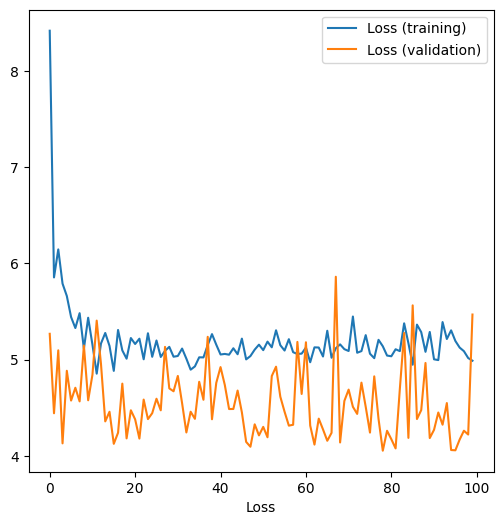

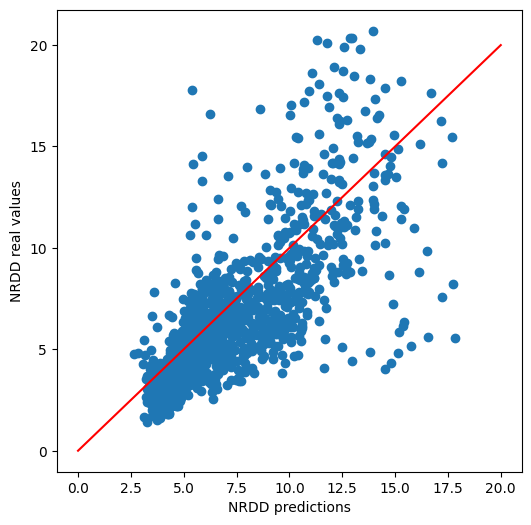

In [47]:
# Plot of the evoluation of the MSE during the training

fig = plt.figure(figsize=(6, 6))
plt.plot(history.history['loss'], label='Loss (training)')
plt.plot(history.history['val_loss'], label='Loss (validation)')
plt.xlabel('Epochs')
plt.xlabel('Loss')
plt.legend()
plt.show()

fig = plt.figure(figsize=(6, 6))
plt.scatter(y_pred, y_test)
plt.plot([0, 20], [0, 20], color='r')
plt.xlabel('NRDD predictions')
plt.ylabel('NRDD real values')
plt.show()

The trend of the loss function is dropping during the first 20 epochs. The predictions remain not stable afterwards. We can also see that the model has not yet over-learned the training dataset since it shows comparable skill on train and validation sets.

### Modeling the standardized dataset with a pipeline and perform some transformations to the target variable

The pipeline framework performs the standardization during the model evaluation process and prevents data leakage from each test set cross validation fold into the training data. We will try to predict a transformation of the NRDD instead of the target variable itself. The cross-validation scoring will highlight the best transformation.

In [48]:
preprocessor = ColumnTransformer(
                        transformers=[
                                ('numerical', StandardScaler(), lst_expl),
                                ('categorical', 'passthrough', lst_slot_class)]                              
                        )

pipe = Pipeline(steps=[
                    ('preprocessor', preprocessor),
                    ('mlp', KerasRegressor(model=baseline_model, epochs=100, batch_size=32, validation_split=0.2, verbose=0))
                    ])
                    

In [49]:
X = df_params[lst_expl + lst_slot_class]
y = df_params[['long_disp_nrdd']]

In [50]:
dict_transfs = {'NoTransformation': FunctionTransformer(lambda y: y),
                'Inverse': FunctionTransformer(lambda y: 1/y),
                'InverseSquare': FunctionTransformer(lambda y: 1/y**2),
                'Logarithm': FunctionTransformer(np.log10),
                'InverseLogarithm': FunctionTransformer(lambda y: 1/np.log10(y)),
                'LogarithmInverse': FunctionTransformer(lambda y: np.log10(1/y)),
                'StandardScaler': StandardScaler(),
                'PowerTransformer': PowerTransformer(),
                'QuantileTransformer': QuantileTransformer(),
                'RobustScaler': RobustScaler(),
                'RootSquare': FunctionTransformer(lambda y: np.sqrt(y)),
                'InverseRootSquare': FunctionTransformer(lambda y: 1/np.sqrt(y))
            }

results = pd.DataFrame()

for name, transf in dict_transfs.items():

    print ('---------------')
    print ('** Transformation:', name)

    y_transf = transf.fit_transform(y)    
    X_train, X_test, y_train, y_test = train_test_split(X, y_transf, test_size = 0.2, random_state=55)

    scores = cross_val_score(pipe, X_train, y_train, cv=kfold)
    results[name] = pd.DataFrame([scores.mean(), scores.std()], index=['Score Mean', 'Standard Deviation'])

results

---------------
** Transformation: NoTransformation
---------------
** Transformation: Inverse


---------------
** Transformation: InverseSquare
---------------
** Transformation: Logarithm
---------------
** Transformation: InverseLogarithm
---------------
** Transformation: LogarithmInverse
---------------
** Transformation: StandardScaler
---------------
** Transformation: PowerTransformer
---------------
** Transformation: QuantileTransformer
---------------
** Transformation: RobustScaler
---------------
** Transformation: RootSquare
---------------
** Transformation: InverseRootSquare


,NoTransformation,Inverse,InverseSquare,Logarithm,InverseLogarithm,LogarithmInverse,StandardScaler,PowerTransformer,QuantileTransformer,RobustScaler,RootSquare,InverseRootSquare
Score Mean,0.526962,0.060043,-0.20658,0.352796,0.430169,0.405230,0.341592,0.558783,0.455337,0.397212,0.467026,0.107562
Standard Deviation,0.049655,0.226095,0.07796,0.211038,0.063088,0.067946,0.115209,0.052739,0.101132,0.035694,0.057768,0.266194


The PowerTransformer provides the best score of cross-validation and will be chosen in the next optimization steps. This transformation is used to make numerical data more Gaussian-like by stabilizing variance and reducing skewness.

### First tuning of the Neural Network topology

The following models will work with the transformed target variable. The structure of a network network is the biggest leverage to improve the performance of the model (number of layers and neurons, activation functions, ...). Then we use the GridSearch technique to optimize this model hyperparameters.

In [51]:
X = df_params[lst_expl + lst_slot_class]
y = df_params[['long_disp_nrdd']]

transf = PowerTransformer()
y_transf = transf.fit_transform(y) 

X_train, X_test, y_train, y_test = train_test_split(X, y_transf, test_size = 0.2, random_state=55)

A new function is defined taking the tuning parameters as arguments:
* Number of epochs and batch size
* Number of neurons of the hidden layer (default: number of input variables)
* Learning rate of the optimizer
* Initialization of the network weights
* Neuron activation function

In [61]:
def tuning_model(init_mode='normal', activation='relu', nb_neurons=num_expl):
    model = Sequential()
    model.add(Dense(nb_neurons, input_shape=(num_expl,), kernel_initializer=init_mode, activation=activation))
    model.add(Dense(1, kernel_initializer=init_mode))
    model.compile(loss='mse', optimizer=tf.optimizers.Adam(learning_rate=0.1))
    return model

preprocessor = ColumnTransformer(
                        transformers=[
                                ('numerical', StandardScaler(), lst_expl),
                                ('categorical', 'passthrough', lst_slot_class)]                              
                        )

pipe_tuning = Pipeline(steps=[
                    ('preprocessor', preprocessor),
                    ('mlp', KerasRegressor(model=tuning_model, epochs=100, batch_size=32, validation_split=0.2, verbose=0, shuffle=True, random_state=55))
                    ])

* The weight initialization is identical for each layer and picked by default according a normal distribution
* The default activation function is reLU

#### Tune the batch size and number of epochs

In [62]:
lst_batch_size = [100, 250, 500, 750, 1000]
lst_epochs = [75, 100, 125, 140, 150, 160]
params = {'mlp__batch_size': lst_batch_size, 'mlp__epochs': lst_epochs}

In [63]:
grid = GridSearchCV(estimator=pipe_tuning, param_grid=params, n_jobs=-1, cv=5)
grid_result = grid.fit(X_train, y_train)

means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
parameters = grid_result.cv_results_['params']

for mean, std, parameter in zip(means, stds, parameters):
    print ('%f (%f) with: %r' % (mean, std, parameter))

print ('Best score:', grid_result.best_score_)
print ('Best parameters:', grid_result.best_params_)

0.716255 (0.021294) with: {'mlp__batch_size': 100, 'mlp__epochs': 75}
0.729940 (0.026365) with: {'mlp__batch_size': 100, 'mlp__epochs': 100}
0.718818 (0.020268) with: {'mlp__batch_size': 100, 'mlp__epochs': 125}
0.744511 (0.024382) with: {'mlp__batch_size': 100, 'mlp__epochs': 140}
0.741436 (0.019158) with: {'mlp__batch_size': 100, 'mlp__epochs': 150}
0.744471 (0.011927) with: {'mlp__batch_size': 100, 'mlp__epochs': 160}
0.770499 (0.019211) with: {'mlp__batch_size': 250, 'mlp__epochs': 75}
0.779474 (0.018995) with: {'mlp__batch_size': 250, 'mlp__epochs': 100}
0.731223 (0.032184) with: {'mlp__batch_size': 250, 'mlp__epochs': 125}
0.779398 (0.027082) with: {'mlp__batch_size': 250, 'mlp__epochs': 140}
0.774294 (0.024573) with: {'mlp__batch_size': 250, 'mlp__epochs': 150}
0.774663 (0.021521) with: {'mlp__batch_size': 250, 'mlp__epochs': 160}
0.782627 (0.014745) with: {'mlp__batch_size': 500, 'mlp__epochs': 75}
0.783378 (0.009811) with: {'mlp__batch_size': 500, 'mlp__epochs': 100}
0.782716 

* Best batch size: 750
* Best number of epochs: 160

#### Tune the learning rate of the Adam optimizer

In [64]:
def start_tuning_model(init_mode='normal', activation='relu', nb_neurons=num_expl):
    model = Sequential()
    model.add(Dense(nb_neurons, input_shape=(num_expl,), kernel_initializer=init_mode, activation=activation))
    model.add(Dense(1, kernel_initializer=init_mode))
    return model

preprocessor = ColumnTransformer(
                        transformers=[
                                ('numerical', StandardScaler(), lst_expl),
                                ('categorical', 'passthrough', lst_slot_class)]                              
                        )

pipe_start_tuning = Pipeline(steps=[
                    ('preprocessor', preprocessor),
                    ('mlp', KerasRegressor(model=start_tuning_model, loss='mse', optimizer='Adam', epochs=160, batch_size=750, validation_split=0.2, verbose=0, shuffle=True, random_state=55))
                    ])

In [65]:
lst_learning_rate = np.linspace(-2, 1, 20)
params = {'mlp__optimizer__learning_rate': 10**lst_learning_rate} 

grid = GridSearchCV(estimator=pipe_start_tuning, param_grid=params, n_jobs=-1, cv=5)
grid_result = grid.fit(X_train, y_train)

means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
parameters = grid_result.cv_results_['params']

for mean, std, parameter in zip(means, stds, parameters):
    print ('%f (%f) with: %r' % (mean, std, parameter))

print ('Best score:', grid_result.best_score_)
print ('Best parameters:', grid_result.best_params_)

0.792700 (0.014071) with: {'mlp__optimizer__learning_rate': 0.01}
0.811887 (0.016678) with: {'mlp__optimizer__learning_rate': 0.01438449888287663}
0.804930 (0.013333) with: {'mlp__optimizer__learning_rate': 0.0206913808111479}
0.814415 (0.014709) with: {'mlp__optimizer__learning_rate': 0.029763514416313176}
0.808725 (0.016422) with: {'mlp__optimizer__learning_rate': 0.04281332398719394}
0.813223 (0.016229) with: {'mlp__optimizer__learning_rate': 0.06158482110660264}
0.801154 (0.021463) with: {'mlp__optimizer__learning_rate': 0.08858667904100823}
0.785551 (0.014013) with: {'mlp__optimizer__learning_rate': 0.12742749857031335}
0.797148 (0.012063) with: {'mlp__optimizer__learning_rate': 0.18329807108324356}
0.780385 (0.018206) with: {'mlp__optimizer__learning_rate': 0.26366508987303583}
0.757100 (0.030335) with: {'mlp__optimizer__learning_rate': 0.37926901907322497}
0.723728 (0.046398) with: {'mlp__optimizer__learning_rate': 0.5455594781168517}
0.620315 (0.101014) with: {'mlp__optimizer__

The learning rate shows an optimum between 0.02 and 0.04. The value 0.0230 is kept for the further optimizations.

#### Tune the number of neurons of the hidden layer

In the baseline model, the hidden layer has the same size as the input layer. We tune it between 15 and 34 neurons.

In [66]:
def start_tuning_model(init_mode='normal', activation='relu', nb_neurons=num_expl):
    model = Sequential()
    model.add(Dense(nb_neurons, input_shape=(num_expl,), kernel_initializer=init_mode, activation=activation))
    model.add(Dense(1, kernel_initializer=init_mode))
    model.compile(loss='mse', optimizer=Adam(learning_rate=0.0230))

    return model

preprocessor = ColumnTransformer(
                        transformers=[
                                ('numerical', StandardScaler(), lst_expl),
                                ('categorical', 'passthrough', lst_slot_class)]                              
                        )

pipe_start_tuning = Pipeline(steps=[
                    ('preprocessor', preprocessor),
                    ('mlp', KerasRegressor(model=start_tuning_model, epochs=160, batch_size=750, validation_split=0.2, verbose=0, shuffle=True, random_state=55))
                    ])

In [67]:
lst_nb_neurons = np.arange(15, 35, 1)
params = {'mlp__model__nb_neurons': lst_nb_neurons}

grid = GridSearchCV(estimator=pipe_start_tuning, param_grid=params, n_jobs=-1, cv=5)
grid_result = grid.fit(X_train, y_train)

means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
parameters = grid_result.cv_results_['params']

for mean, std, parameter in zip(means, stds, parameters):
    print ('%f (%f) with: %r' % (mean, std, parameter))

print ('Best score:', grid_result.best_score_)
print ('Best parameters:', grid_result.best_params_)

0.804799 (0.012645) with: {'mlp__model__nb_neurons': 15}
0.797643 (0.015929) with: {'mlp__model__nb_neurons': 16}
0.817699 (0.014634) with: {'mlp__model__nb_neurons': 17}
0.807482 (0.008420) with: {'mlp__model__nb_neurons': 18}
0.802285 (0.011767) with: {'mlp__model__nb_neurons': 19}
0.800438 (0.017358) with: {'mlp__model__nb_neurons': 20}
0.794768 (0.009680) with: {'mlp__model__nb_neurons': 21}
0.810044 (0.017320) with: {'mlp__model__nb_neurons': 22}
0.808424 (0.026310) with: {'mlp__model__nb_neurons': 23}
0.814003 (0.020195) with: {'mlp__model__nb_neurons': 24}
0.810281 (0.012491) with: {'mlp__model__nb_neurons': 25}
0.808821 (0.019066) with: {'mlp__model__nb_neurons': 26}
0.803461 (0.022744) with: {'mlp__model__nb_neurons': 27}
0.804554 (0.013074) with: {'mlp__model__nb_neurons': 28}
0.816055 (0.020070) with: {'mlp__model__nb_neurons': 29}
0.816969 (0.008512) with: {'mlp__model__nb_neurons': 30}
0.812745 (0.017744) with: {'mlp__model__nb_neurons': 31}
0.812690 (0.021920) with: {'mlp

* Best number of neurons for the hidden layer: 17

#### Tune the weight initialization and the activation function

In [68]:
def start_tuning_model(init_mode='normal', activation='relu'):
    model = Sequential()
    model.add(Dense(17, input_shape=(num_expl,), kernel_initializer=init_mode, activation=activation))
    model.add(Dense(1, kernel_initializer=init_mode))
    model.compile(loss='mse', optimizer=Adam(learning_rate=0.0230))
    
    return model

preprocessor = ColumnTransformer(
                        transformers=[
                                ('numerical', StandardScaler(), lst_expl),
                                ('categorical', 'passthrough', lst_slot_class)]                              
                        )

pipe_start_tuning = Pipeline(steps=[
                    ('preprocessor', preprocessor),
                    ('mlp', KerasRegressor(model=start_tuning_model, epochs=160, batch_size=750, validation_split=0.2, verbose=0, shuffle=True, random_state=55))
                    ])

In [69]:
lst_init_mode = ['normal', 'uniform', 'lecun_uniform', 'zero', 'glorot_normal', 'glorot_uniform', 'he_normal', 'he_uniform']
lst_activation = ['relu', 'softmax', 'softplus', 'softsign', 'tanh', 'sigmoid', 'hard_sigmoid', 'linear']
params = {'mlp__model__init_mode': lst_init_mode, 'mlp__model__activation': lst_activation}

grid = GridSearchCV(estimator=pipe_start_tuning, param_grid=params, n_jobs=-1, cv=5)
grid_result = grid.fit(X_train, y_train)

means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
parameters = grid_result.cv_results_['params']

for mean, std, parameter in zip(means, stds, parameters):
    print ('%f (%f) with: %r' % (mean, std, parameter))

print ('Best score:', grid_result.best_score_)
print ('Best parameters:', grid_result.best_params_)

0.817699 (0.014634) with: {'mlp__model__activation': 'relu', 'mlp__model__init_mode': 'normal'}
0.806581 (0.024033) with: {'mlp__model__activation': 'relu', 'mlp__model__init_mode': 'uniform'}
0.818553 (0.016339) with: {'mlp__model__activation': 'relu', 'mlp__model__init_mode': 'lecun_uniform'}
-0.000679 (0.001237) with: {'mlp__model__activation': 'relu', 'mlp__model__init_mode': 'zero'}
0.786381 (0.014667) with: {'mlp__model__activation': 'relu', 'mlp__model__init_mode': 'glorot_normal'}
0.797192 (0.017292) with: {'mlp__model__activation': 'relu', 'mlp__model__init_mode': 'glorot_uniform'}
0.785258 (0.017372) with: {'mlp__model__activation': 'relu', 'mlp__model__init_mode': 'he_normal'}
0.788752 (0.017208) with: {'mlp__model__activation': 'relu', 'mlp__model__init_mode': 'he_uniform'}
0.839979 (0.019428) with: {'mlp__model__activation': 'softmax', 'mlp__model__init_mode': 'normal'}
0.833365 (0.016573) with: {'mlp__model__activation': 'softmax', 'mlp__model__init_mode': 'uniform'}
0.84

The best results are obtained for:
* the Softmax activation functions
* the Glorot uniform initializer.
